# Welcome to my Data Insights Hackathon!!!

## Motivation

This hackathon will take place over the time period of 10am – 6pm Saturday 5/20/2017 and 10am-5pm Sunday 5/21/2017 and will feature one participant, ME!!!

The goal of this hackathon is for me to create a public project to demonstrate both my understanding and enthusiasm for deep learning. Most people build their portfolios over their career and so there is no need for them to do this kind of hackathon unfortunately, the best examples of my work are under lock and key in the code bases of a large financial institution, so here we go!

# My Project – Deep Factors for Financial instruments

Part of my motivation for choosing this paper is that I believe it will be useful to have domain expertise in a topic in order to create something interesting given the short time frame. The project I have decided to undertake is roughly based on the paper Deep Portfolio Theory by _____ found here LINK. Very quickly, I will try to summarize the high level concepts of the paper in the simplest terms that I can. I will then explain how it fits into the academic literature, why I think it is important, how I have deviated from it, and highlight some things that went wrong.

Prior to this paper portfolios of stocks were create with something called markowitz portfolio optimization. This sounds fancy and Russian so immediately you think its is extremely difficult and only a mathematical magician could understand it. I assure you this is not the case. It is actually very simple and is based off the concept that if you have a bunch of stocks you want to pick a portfolio that trades off the between the potential returns of the stock (  :-) yeah lets make money!) and the risk of a stock (  : - ( Boo! I don’t want to lose money). In order to assess what a stocks return is this clever Russian simply took the average of each stocks’ returns over some time period. To assess the risk portion of the equation he took the variance of the stocks returns. So simply put he looked at how much the stocks went up/down and he looked at how much the wiggled around before during the time they were going up/down. The really smart thing that Markowitz did was that he proved that it may be a good idea to include stocks with very small returns (maybe even negative)  in your portfolio to generate a better portfolio. This blew people away because it is not immediately intuitive to do this. The way this makes sense though is because, if you have a stock that is uncorrelated or negatively correlated with other stocks when the rest of your portfolio goes down that stock will go up and so you will reduce the OVERALL risk of the entire portfolio by including it. Look at the image below and it will help you visualize this:

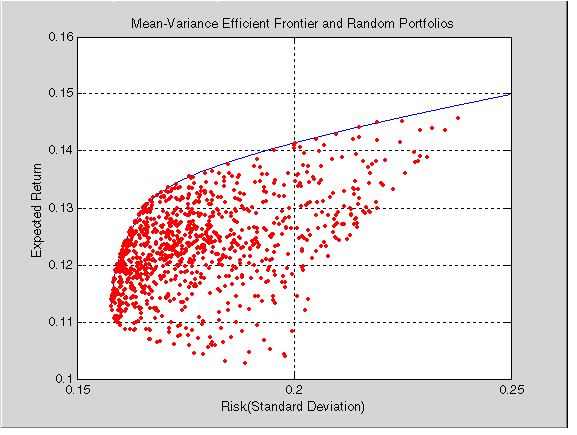

In [1]:
from IPython.display import Image
Image(filename='Efficient_Frontier.png') 

In the graph the x axis is the amount of risk and the y axis is the return. So intuitively being in the bottom right corner is very bad (high risk/ low returns) and being in the upper left is great! (low risk high rewards) Every red dot represents a single stock and what their past risk vs return. The blue line is what’s called the optimal frontier. This is just fancy speak for the best return you can make for an given amount of risk you can take. Markowitz showed that you can create this optimal portfolio by a linear combination of stocks. You may have heard of the term diversification when people talk about your 401k, this is what they are talking about. 

So what does this have to do with our hackathon or paper? Well when I was explaining this to you maybe you started to think, that somethings were rather…. Simplistic, or even a bit naive. For example, the only measure of risk is the variance of a stock’s past returns? Or simply you are going to model the returns by looking at an average? Perhaps you even noticed the more subtle point that when you take the covariance between stocks you are modeling similarity as a linear relationship. Or even that you are making assumptions about the returns are lognormal(usually you take log returns). That doesn’t seem like it is always going to be true! If you had these thoughts then it turns out you would be correct. But, I assure you from first hand experience in my many years on Wall Street, this is how it is done today in practice. (There are slight variations which take into account hand crafted factors such as Barra models but, that is out of scope)

Enter Deep Portfolio Theory: The way they authors differ from Markowitz is to start they take a series of returns and run them through an autoencoder. A simple explanation of an autoencoder is that it is a model that you feed in data and then you try to predict that same data. The caveat here being that you constrain this model in some way either by having a lower capacity than the data’s dimensions or by regularizing it in some way. The part before the bottleneck is called the encoder and the part after is called the decoder. I am a visual learner so the figure below helps.  

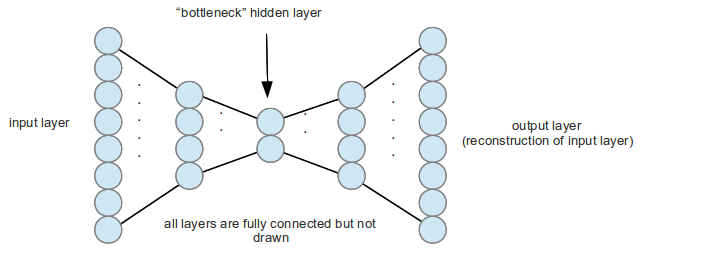

In [2]:
Image(filename='AutoencoderPicture.png') 

As you may have guessed both by the picture and Deep part of the title Deep Portfolio Theory they use a Neural Network as the autoencoder. In the paper they use 5 hidden units in one layer neural network and regularize the neural network with L2 regularization and a lambda factor that they tune in a validation stage. After they do this they look at the encodings and do a 2-norm on the embedding vectors and take the top ten most similar to minimize “mutual information” and then start adding other securities to see what the efficient frontier looks like. They go further and try to use it to track a benchmark….. blah blah blah.

The thing that is significant and the thing that you should take away from this is that they created an efficient frontier from data. Using a neural network with relu activations they allow for there to be nonlinear dependencies and learn the these nonlinear risk relationships between stocks from data. This is quite amazing and a potentially HUGE leap forward. 

## My Implementation 

I follow this paper very roughly. First of all I have spent 3 hours going through quantopian which gives huge amounts of minute by minute data for all stocks. The problem is they contain this information in a backtester so you can not get it out and their research environment does not support theano, tensorflow or keras…. F@!%. So due to lack of data, I manually scraped yahoo finance and got five years of historical data from five stocks: SPY,  JCP,  AAPL, GOOG, and XOM. 

The Data has to be normalized and partitioned for use in the autoencoder. So I drop columns that are not useful from the data and create rolling time series windows. Using a function I turn all the columns into return series. This code is not the most pretty/efficient I know! Its a HACKATHON get over it. Important to note that I create a 20 period window and then create another 20 period window that is only shifted by one. This introduces some autocorrelation in factors, but from experience this is preferable to the alternative which, creating time series that are bias by start data. Also, I will be shuffling these series and it provides more data to train on. 

In [3]:
%matplotlib notebook
%matplotlib inline

import os
import time
import datetime as dt
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
data = pd.read_csv('SPY.csv')
data.iloc[0,2]

132.020004

In [5]:
# A function that normalizes all the sequences
def normalize_window(window_data):
    normalized_data =[]
    for window in window_data:
        window = window.drop(window.columns[[0]],axis=1)
        normalized_data.append(window.values/window.iloc[0].values-1)
    return normalized_data


def load_stock_data(ticker, sequence_length=20, train_split =0.8, val_test_split=0.5, peak=0):
    data = pd.read_csv(ticker + '.csv')
    result = []
    # here we rearrange the columns and get rid of the non_adjusted close
    data = data[data.columns[[0,1,2,3,6,5]]]
    
    #here we create a list of dataframes. that increment the day by one and and have sequence length sequence length
    # this is important because it then allows us to apply a function to each sequence to normalize it into return space
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    #normalize the data and get the shape
    result = np.array(normalize_window(result))
    print("The shape of the whole dataset is: {}".format(result.shape))

    # get the row that splits test data from the rest
    train_row = int(round(train_split*result.shape[0]))

    # get the training set (note that this is not split X_train or Y_train yet because we only
    # care about the auto encoding and wont use this LSTM for prediction)
    train = result[:train_row,:]

    # Get the validation and testing portion of the data
    val_test = result[train_row:,:]

    #get the row we split test vs validation
    test_row =int(round(val_test_split*val_test.shape[0]))

    #get the validation set
    validation =val_test[:test_row,:]

    #get the test set
    test = val_test[test_row:,:]

    #now we print out the shape

    print("Training set shape: {}".format(train.shape))
    print("Validation set shape: {}".format(validation.shape))
    print("Test set shape: {}".format(test.shape))
    if peak ==1:
        print(data.head(3))
    return train, validation, test

Now I create train, validation, test sets for all of the tickers independently. I could use a flag but,  I am lazy. I will use them separately later so there is a point to this.

In [6]:
# GET ALL THE DATA FOR THE STOCKS
# Known bug: This could be done much better and faster. this is also not scalable to hundred of securities
# we want to keep them seperate though so we can test their embeddings seperately.
# also need to implement a check that the dimensions are the same for the data. right now you can just visually inspect

train_SPY, validation_SPY, test_SPY = load_stock_data('SPY',20, 0.8, 0.5)
train_GOOG, validation_GOOG, test_GOOG = load_stock_data('GOOG',20, 0.8, 0.5)
train_AAPL, validation_AAPL, test_AAPL = load_stock_data('AAPL',20, 0.8, 0.5)
train_JCP, validation_JCP, test_JCP = load_stock_data('JCP',20, 0.8, 0.5)
train_XOM, validation_XOM, test_XOM = load_stock_data('XOM',20, 0.8, 0.5,1)

The shape of the whole dataset is: (1238, 20, 5)
Training set shape: (990, 20, 5)
Validation set shape: (124, 20, 5)
Test set shape: (124, 20, 5)
The shape of the whole dataset is: (1238, 20, 5)
Training set shape: (990, 20, 5)
Validation set shape: (124, 20, 5)
Test set shape: (124, 20, 5)
The shape of the whole dataset is: (1238, 20, 5)
Training set shape: (990, 20, 5)
Validation set shape: (124, 20, 5)
Test set shape: (124, 20, 5)
The shape of the whole dataset is: (1238, 20, 5)
Training set shape: (990, 20, 5)
Validation set shape: (124, 20, 5)
Test set shape: (124, 20, 5)
The shape of the whole dataset is: (1238, 20, 5)
Training set shape: (990, 20, 5)
Validation set shape: (124, 20, 5)
Test set shape: (124, 20, 5)
         Date       Open       High        Low    Volume  Adj Close
0  2012-05-21  81.419998  82.129997  81.070000  13730400  82.040001
1  2012-05-22  82.139999  82.839996  81.519997  13790000  81.949997
2  2012-05-23  81.790001  82.080002  79.959999  17582200  82.04000

Combine the individual ticker datasets together in their respective train, validation, test partitions.


In [7]:
train = np.concatenate((train_SPY,train_GOOG,train_AAPL,train_JCP,train_XOM), axis=0)
print('Shape of Total Train: {}'.format(train.shape))
validation = np.concatenate((validation_SPY,validation_GOOG,validation_AAPL,validation_JCP,validation_XOM), axis=0)
print('Shape of Total Validation: {}'.format(validation.shape))
test = np.concatenate((test_SPY, test_GOOG, validation_AAPL, test_JCP, test_XOM), axis=0)
print('Shape of Total Test: {}'.format(test.shape))

Shape of Total Train: (4950, 20, 5)
Shape of Total Validation: (620, 20, 5)
Shape of Total Test: (620, 20, 5)


## AUTOENCODERS

Here is where I start to get off script. I didn’t know what kind of NN for the autoencoder but, because the data is made up of timeseries (and I want to show of my mad DL skills) so I have decided to do both a fully connected autoencoder and an LSTM autoencoder. Below are my two autoencoders.

### LSTM AUTOENCODER 

In [8]:
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model


# This change of variables names is just to help me with understanding the network
# NOTE: LATENT_DIM IS A HYPERPARAMETER I PICKED 5 BECAUSE OF THE PAPER
timesteps = train.shape[1] #this is the sequence_length
input_dim = train.shape[2] # this is the number of parameters the stock has
latent_dim = 7

# My inputs
inputs = Input(shape=(timesteps, input_dim))
# They get encoded into a certain latent dimension
encoded = LSTM(latent_dim)(inputs)

#we then take the encoded vector and run it through another lstm
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(input_dim, return_sequences=True)(decoded)

#we put it together in a single model
sequence_autoencoder = Model(inputs, decoded)

#create an incoder
encoder = Model(inputs, encoded)

# I TRIED TO CREATE A DECODER BUT I FAILED. TO DO create a decoder
# create a placeholder for an encoded (5-dimensional) input
#encoded_input = Input(shape=(latent_dim,))
# retrieve the last layer of the autoencoder model
#decoder_layer = sequence_autoencoder.layers[-1]
# create the decoder model
#decoder = Model(encoded_input, decoder_layer(encoded_input))

Using TensorFlow backend.


### Fully-Connected Autoencoder

In [ ]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## Yeah I'll get a little fancy for you.

So…… here is the other thing. You may have noticed if you were looking at  my code and the dimensions of my data that I have three dimensions to each of my stocks dataframes. The last dimension has a length of five…. well the truth is because I don’t have enough data to make a true portfolio I feel like I need to do something a little different. What I decided is that while its cool to look at risk relationships in terms of some nonlinear combination of returns, what if you throw in some other information as well? This was not really possible in the markowitz framework but, this is deep learning BABY! We are creating parameters learned from data we just throw in what data we want. I decided to include not only the returns from close of business to close of business but, also the returns from the highs of the day, the lows of the day, the open of day, and even the changes in the volume of stock traded. Ok lets check it out. Here I am feeding the autoencoder my data.

### run the autoencoder

In [9]:
from keras.callbacks import TensorBoard
n_epochs = 350
batch_size=64

sequence_autoencoder.compile(optimizer='RMSprop', loss='mean_squared_error')

sequence_autoencoder.fit(train, train,
                epochs=n_epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(validation, validation),
                verbose=0,
                callbacks=[TensorBoard(log_dir='/tmp/lstmautoencoder',histogram_freq=5,
                                      write_images=True,
                                      embeddings_freq=5)])

INFO:tensorflow:Summary name lstm_1/kernel:0 is illegal; using lstm_1/kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/kernel:0 is illegal; using lstm_1/kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/recurrent_kernel:0 is illegal; using lstm_1/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/recurrent_kernel:0 is illegal; using lstm_1/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/bias:0 is illegal; using lstm_1/bias_0 instead.
INFO:tensorflow:Summary name lstm_1/bias:0 is illegal; using lstm_1/bias_0 instead.
INFO:tensorflow:Summary name lstm_2/kernel:0 is illegal; using lstm_2/kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/kernel:0 is illegal; using lstm_2/kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/recurrent_kernel:0 is illegal; using lstm_2/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/recurrent_kernel:0 is illegal; using lstm_2/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/bias:0 is il

In [7]:
validation.shape

(620, 20, 5)

In [8]:
n=0
encoder.predict(validation).shape

(620, 7)

In [9]:
sequence_autoencoder.predict(validation)[n,:,0]

array([ 0.00292402,  0.00964535,  0.01749971,  0.02381579,  0.02732249,
        0.02797336,  0.02605207,  0.0217987 ,  0.01552378,  0.00782137,
       -0.00027856, -0.0072995 , -0.01156481, -0.01180954, -0.00801632,
       -0.00178975,  0.00444961,  0.00890841,  0.01102644,  0.01096166], dtype=float32)

In [ ]:
#int(np.random.rand(0,validation.shape[0]))
validation.shape[0]
np.random.randint(low=0,high=validation.shape[0])

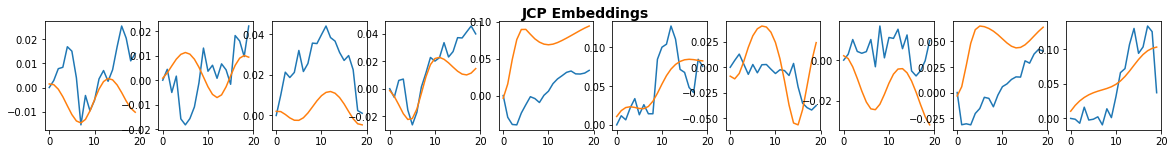

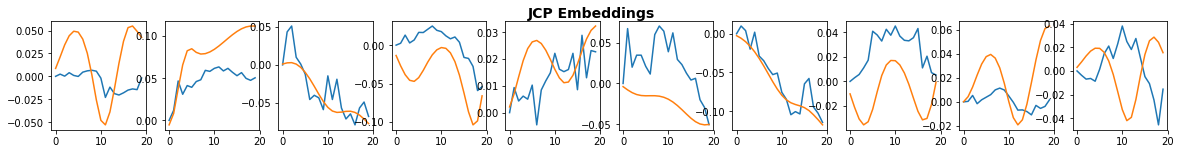

In [100]:
'''Here we are creating plots to look at our predictions. We grab 10 sequences at random from the validation set 
    plot them against what the autoencoder reconstructs. Some of these examples you can see do a very good job 
    at getting the average values and general shape of the time series correct. However the predictionsare all very
    smoothed. This is as we would expect since we know that autoencoders are very good at noise reduction.In general
    one property that is nice is the slope of the ts is correct.'''
for n in range(2):
    stock_name='JCP'
    j = 10
    plt.figure(figsize=(20, 2))
    plt.suptitle(stock_name+' Embeddings', fontsize=14, fontweight='bold')

    for i in range(j):
        n =np.random.randint(low=0,high=validation.shape[0])
        ax = plt.subplot(1, j, i+1)
        plt.plot(np.array(range(validation[n,:,0].shape[0])),validation[n,:,0],np.array(range(validation[n,:,0].shape[0])),sequence_autoencoder.predict(validation)[n,:,0])
    plt.show()
#n=2
#plt.plot(np.array(range(validation[n,:,0].shape[0])),validation[n,:,0],np.array(range(validation[n,:,0].shape[0])),sequence_autoencoder.predict(validation)[n,:,0])

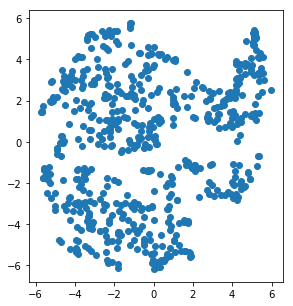

In [64]:
''' Here I attempt to visualize the factors that we have learned from the autoencoder. I have chosen 7 hidden units
so we have 7 different dimensions in order to be able to visualize this more easily i use the t-sne algorithm
to map them into 2d space. This plot does not show much. But, that is not very un reasonable. To properly look at
the factors we should break them up by stock, and by time frame. Factors generally float overtime so it would be
more interesting to see how they change. We also would like to have a larger universe of stocks instead of only 5'''
from sklearn.manifold import TSNE

X_tsne = TSNE(learning_rate=50).fit_transform(encoder.predict(validation))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

In [67]:
encoder.predict(validation_SPY).T.shape

(7, 124)

In [87]:
#spygoog = 2435.7793
#spyaapl =2360.9841
#aaplgoog = 2425.6077
#SPYJCP=2324.2031
#spyxom =2368.3069
#googgoog =2452.7356
#spyspy=2366.6699
#AAPLAAPL=2353.2224
#JCPJCP=2261.0581
b=np.dot(encoder.predict(validation_JCP),encoder.predict(validation_JCP).T)
np.sum(b[np.triu_indices(124)])


2261.0581

In [19]:
from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import quotes_historical_yahoo_ohlc, candlestick_ohlc


# (Year, month, day) tuples suffice as args for quotes_historical_yahoo
date1 = (2004, 2, 1)
date2 = (2004, 4, 12)


mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
alldays = DayLocator()              # minor ticks on the days
weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
dayFormatter = DateFormatter('%d')      # e.g., 12

quotes = quotes_historical_yahoo_ohlc('INTC', date1, date2)
if len(quotes) == 0:
    raise SystemExit

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
ax.xaxis.set_major_locator(mondays)
ax.xaxis.set_minor_locator(alldays)
ax.xaxis.set_major_formatter(weekFormatter)
#ax.xaxis.set_minor_formatter(dayFormatter)

#plot_day_summary(ax, quotes, ticksize=3)
candlestick_ohlc(ax, quotes, width=0.6)

ax.xaxis_date()
ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

/home/johnny/anaconda2/envs/stock_project/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


HTTPError: HTTP Error 502: Connection refused

In [21]:
from matplotlib.finance import candlestick_ohlc

In [23]:
candlestick_ohlc(ax1,validation[0,:,:4])

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [ -8.34695357e-03,  -1.25380915e-02,  -9.32551186e-03,
          4.65024348e-01],
       [ -7.38755132e-03,  -7.53242772e-03,  -2.65753277e-03,
         -3.60312376e-01],
       [ -9.30635582e-03,  -1.41113276e-02,  -8.11754901e-03,
          4.16730956e-02],
       [ -1.66458883e-02,  -1.86402989e-02,  -1.22729460e-02,
         -5.11478540e-02],
       [ -1.39115845e-02,  -1.80205906e-02,  -1.20313390e-02,
         -3.04445144e-01],
       [ -2.11072093e-02,  -1.90216967e-02,  -1.48821120e-02,
         -1.38159072e-01],
       [ -1.38635705e-02,  -1.60183118e-02,  -7.73099123e-03,
         -2.34953639e-01],
       [ -8.34695357e-03,  -6.14985713e-03,  -1.54623110e-03,
         -2.03093723e-01],
       [ -2.63841016e-03,  -5.81618054e-03,  -2.22268547e-03,
         -1.59327355e-01],
       [ -5.61265452e-03,  -1.08218443e-02,  -7.68270171e-03,
         -7.84838329e-02],
       [ -1.07934372e

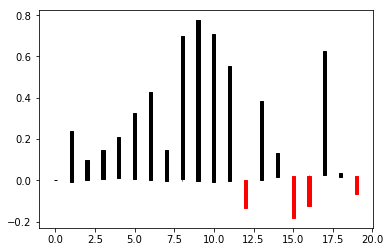

In [59]:

fig = plt.figure()
ax1 = plt.subplot2grid((1,1), (0,0))
candlestick_ohlc(ax1,a)
plt.show()

In [35]:
a =list(range(20)),validation[0,:,:]

In [ ]:
np.array(list(range(20)))

In [57]:
validation[0,3,:]+1

array([ 0.99069364,  0.98588867,  0.99188245,  1.0416731 ,  0.99378167])

In [58]:
a= np.insert(validation[5,:,:],0,np.array(list(range(20))),axis=1)

In [51]:
np.insert(validation[1,:,:],0,np.array(list(range(20))),axis=1).shape

(20, 6)

In [39]:
a = np.array([[1, 1], [2, 2], [3, 3]])

In [42]:
a

array([[1, 1],
       [2, 2],
       [3, 3]])

In [41]:
a.shape

(3, 2)

In [43]:
np.insert(a, 1, 5, axis=1)

array([[1, 5, 1],
       [2, 5, 2],
       [3, 5, 3]])